In [1]:
import xarray as xr
from sea_breeze import sea_breeze_filters, load_model_data, sea_breeze_funcs, utils, filter
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sea_breeze import load_obs
import pandas as pd
import datetime as dt

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35055,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:39343,Total threads: 1
Dashboard: /proxy/45171/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40911,


In [3]:
models=["aus2200_smooth_s4","barra_c_smooth_s2","barra_r","era5"]

F_list = [] 
sbi_list = []
fuzzy_list = []
F_mask_list = []
sbi_mask_list = []
fuzzy_mask_list = []

for model in models:

    print(model)

    if model in ["aus2200_smooth_s4","era5"]:
        sbi_list.append(utils.load_diagnostics("sbi",model))
    else:
        sbi_list.append(np.nan)
    F_list.append(utils.load_diagnostics("F",model))
    fuzzy_list.append(utils.load_diagnostics("fuzzy",model))

    if model in ["aus2200_smooth_s4","era5"]:
        sbi_mask_list.append(xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+model+"/filters/filtered_mask_no_hourly_change_sbi_2*",
                      engine="zarr").mask)
    else:
        sbi_mask_list.append(np.nan)
    F_mask_list.append(xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+model+"/filters/filtered_mask_no_hourly_change_F_2*",
                      engine="zarr").mask)
    fuzzy_mask_list.append(xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+model+"/filters/filtered_mask_no_hourly_change_fuzzy_2*",
                      engine="zarr").mask)

aus2200_smooth_s4
barra_c_smooth_s2
barra_r
era5


In [15]:
def plot_case(ax, diagnostic, mask, u, v, angle_var, orog, lsm, levels, cmap=None, extend=None, plot_uv=True):

    diagnostic.plot(
        ax=ax,
        cmap=cmap,
        levels=levels,
        extend=extend)
    xr.plot.contour(
        mask,
        levels=1,
        colors="k",
        ax=ax)
    if plot_uv:
        xr.Dataset({"u":u,"v":v}).plot.quiver(
            ax=ax,
            x="lon",
            y="lat",
            u="u",
            v="v",
            scale=200)
        xr.plot.contour(
            lsm,
            levels=1,
            colors="k",
            linewidths=0.5,
            ax=ax)
        xr.plot.contourf(
            angle_var,
            ax=ax,
            levels=[0.5,1],
            extend="neither",
            colors=["none"],
            alpha=0,
            hatches=["...."],
            add_colorbar=False)
    else:
        ax.coastlines()
    xr.plot.contourf(
        orog,
        ax=ax,
        levels=[500,10000],
        extend="neither",
        colors=["grey"],
        alpha=0.6,
        hatches=["//"],
        add_colorbar=False)

    ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"rotation":30})

def plot_driver():

    aus2200_angle_ds, _, aus2200_uas, aus2200_vas, _, aus2200_vprime, _ = filter.load_aus2200_filtering_data(
        lon_slice,
        lat_slice,
        time,
        time,
        base_path,
        exp_id)
    aus2200_orog, aus2200_lsm = load_model_data.load_aus2200_static(exp_id,lon_slice,lat_slice)
    
    # barra_c_angle_ds, _, barra_c_uas, barra_c_vas, _, _, _ = filter.load_barra_c_filtering_data(
    #     lon_slice,
    #     lat_slice,
    #     time,
    #     time,
    #     base_path)
    barra_c_orog, barra_c_lsm = load_model_data.load_barra_static("AUST-04",lon_slice, lat_slice)
    
    # barra_r_angle_ds, _, barra_r_uas, barra_r_vas, _, _, _ = filter.load_barra_r_filtering_data(
    #     lon_slice,
    #     lat_slice,
    #     time,
    #     time,
    #     base_path)
    barra_r_orog, barra_r_lsm = load_model_data.load_barra_static("AUS-11",lon_slice, lat_slice)
    
    era5_angle_ds, _, era5_uas, era5_vas, _, era5_vprime, _ = filter.load_era5_filtering_data(
        lon_slice,
        lat_slice,
        time,
        time,
        base_path)
    era5_orog, era5_lsm, _ = load_model_data.load_era5_static(lon_slice, lat_slice, time, time)    

    plt.figure(figsize=[18,18])
    F_levels=[-100,-50,-20,-10,-5,-2,2,5,10,20,50,100]
    sbi_levels=np.linspace(0,1,11)
    fuzzy_levels=np.linspace(0,0.5,11)
    
    ###########
    # AUS2200 #
    ###########
    
    ax=plt.subplot(4,3,1,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":12,"lon":12},boundary="pad").mean(),
        aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":12,"lon":12},boundary="pad").mean(),
        aus2200_angle_ds.variance_interp,
        aus2200_orog,
        aus2200_lsm,
        levels=F_levels,
        cmap="RdBu",
        extend="both")
    
    ax=plt.subplot(4,3,2,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        sbi_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        sbi_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":12,"lon":12},boundary="pad").mean(),
        aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":12,"lon":12},boundary="pad").mean(),
        aus2200_angle_ds.variance_interp,
        aus2200_orog,
        aus2200_lsm,
        levels=sbi_levels,
        cmap="Blues")
    
    ax=plt.subplot(4,3,3,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":12,"lon":12},boundary="pad").mean(),
        aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":12,"lon":12},boundary="pad").mean(),
        aus2200_angle_ds.variance_interp,
        aus2200_orog,
        aus2200_lsm,
        levels=fuzzy_levels,
        extend="max",
        cmap="Blues")
    
    ###########
    # BARRA-C #
    ###########
    
    ax=plt.subplot(4,3,4,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        np.nan,
        np.nan,
        np.nan,
        barra_c_orog,
        barra_c_lsm,
        levels=F_levels,
        cmap="RdBu",
        extend="both",
        plot_uv=False)
    
    ax=plt.subplot(4,3,5,projection=ccrs.PlateCarree())
    
    ax=plt.subplot(4,3,6,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        np.nan,
        np.nan,
        np.nan,
        barra_c_orog,
        barra_c_lsm,
        levels=fuzzy_levels,
        cmap="Blues",
        plot_uv=False)
    
    ###########
    # BARRA-R #
    ###########
    
    ax=plt.subplot(4,3,7,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        np.nan,
        np.nan,
        np.nan,
        barra_r_orog,
        barra_r_lsm,
        levels=F_levels,
        cmap="RdBu",
        extend="both",
        plot_uv=False)
    
    ax=plt.subplot(4,3,8,projection=ccrs.PlateCarree())
    
    ax=plt.subplot(4,3,9,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        np.nan,
        np.nan,
        np.nan,
        barra_r_orog,
        barra_r_lsm,
        levels=fuzzy_levels,
        cmap="Blues",
        plot_uv=False)
    
    ###########
    #  ERA5   #
    ###########
    ax=plt.subplot(4,3,10,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_uas.sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_vas.sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_angle_ds.variance_interp,
        era5_orog/9.8,
        era5_lsm,
        levels=F_levels,
        cmap="RdBu",
        extend="both")
    
    ax=plt.subplot(4,3,11,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        sbi_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        sbi_mask_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_uas.sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_vas.sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_angle_ds.variance_interp,
        era5_orog/9.8,
        era5_lsm,
        levels=sbi_levels,
        cmap="Blues")
    
    ax=plt.subplot(4,3,12,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_uas.sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_vas.sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_angle_ds.variance_interp,
        era5_orog/9.8,
        era5_lsm,
        levels=fuzzy_levels,
        cmap="Blues")

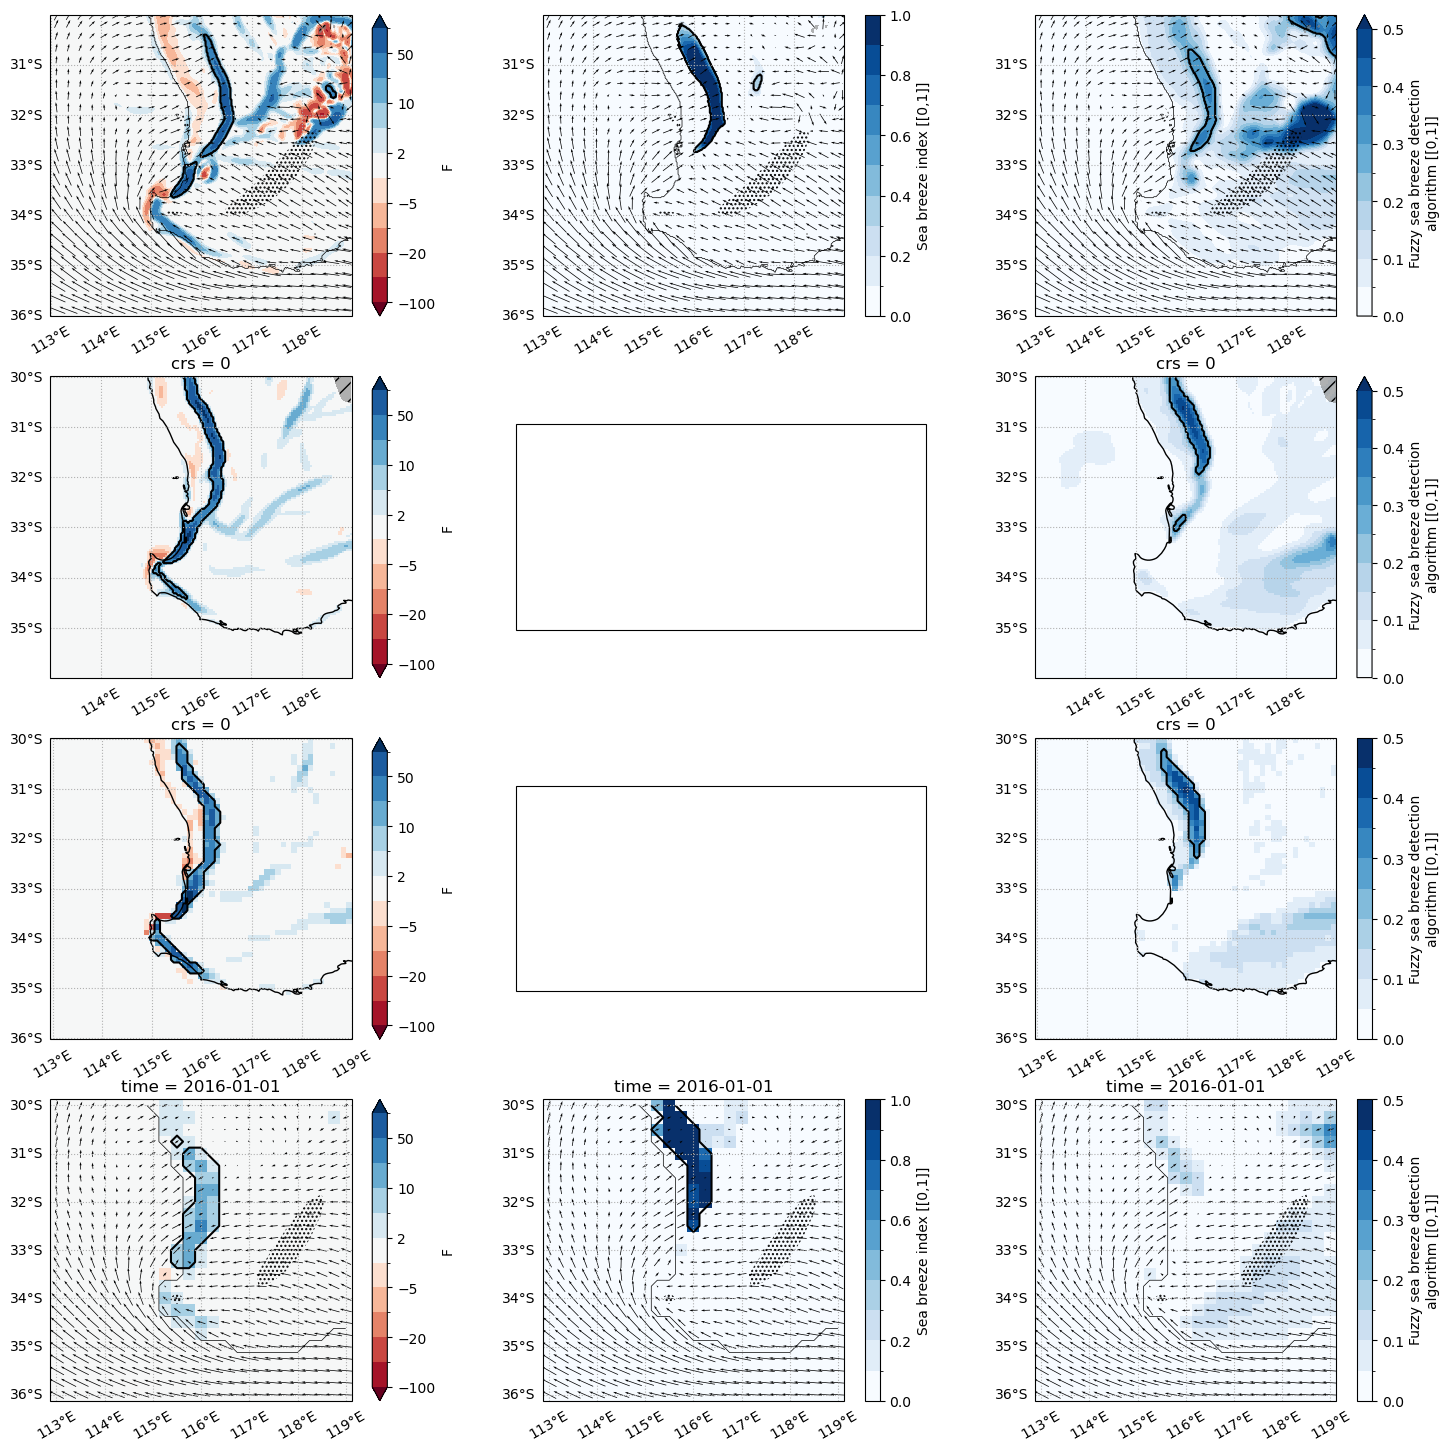

In [16]:
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
time = "2016-01-06 08:00"
exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

plot_driver()

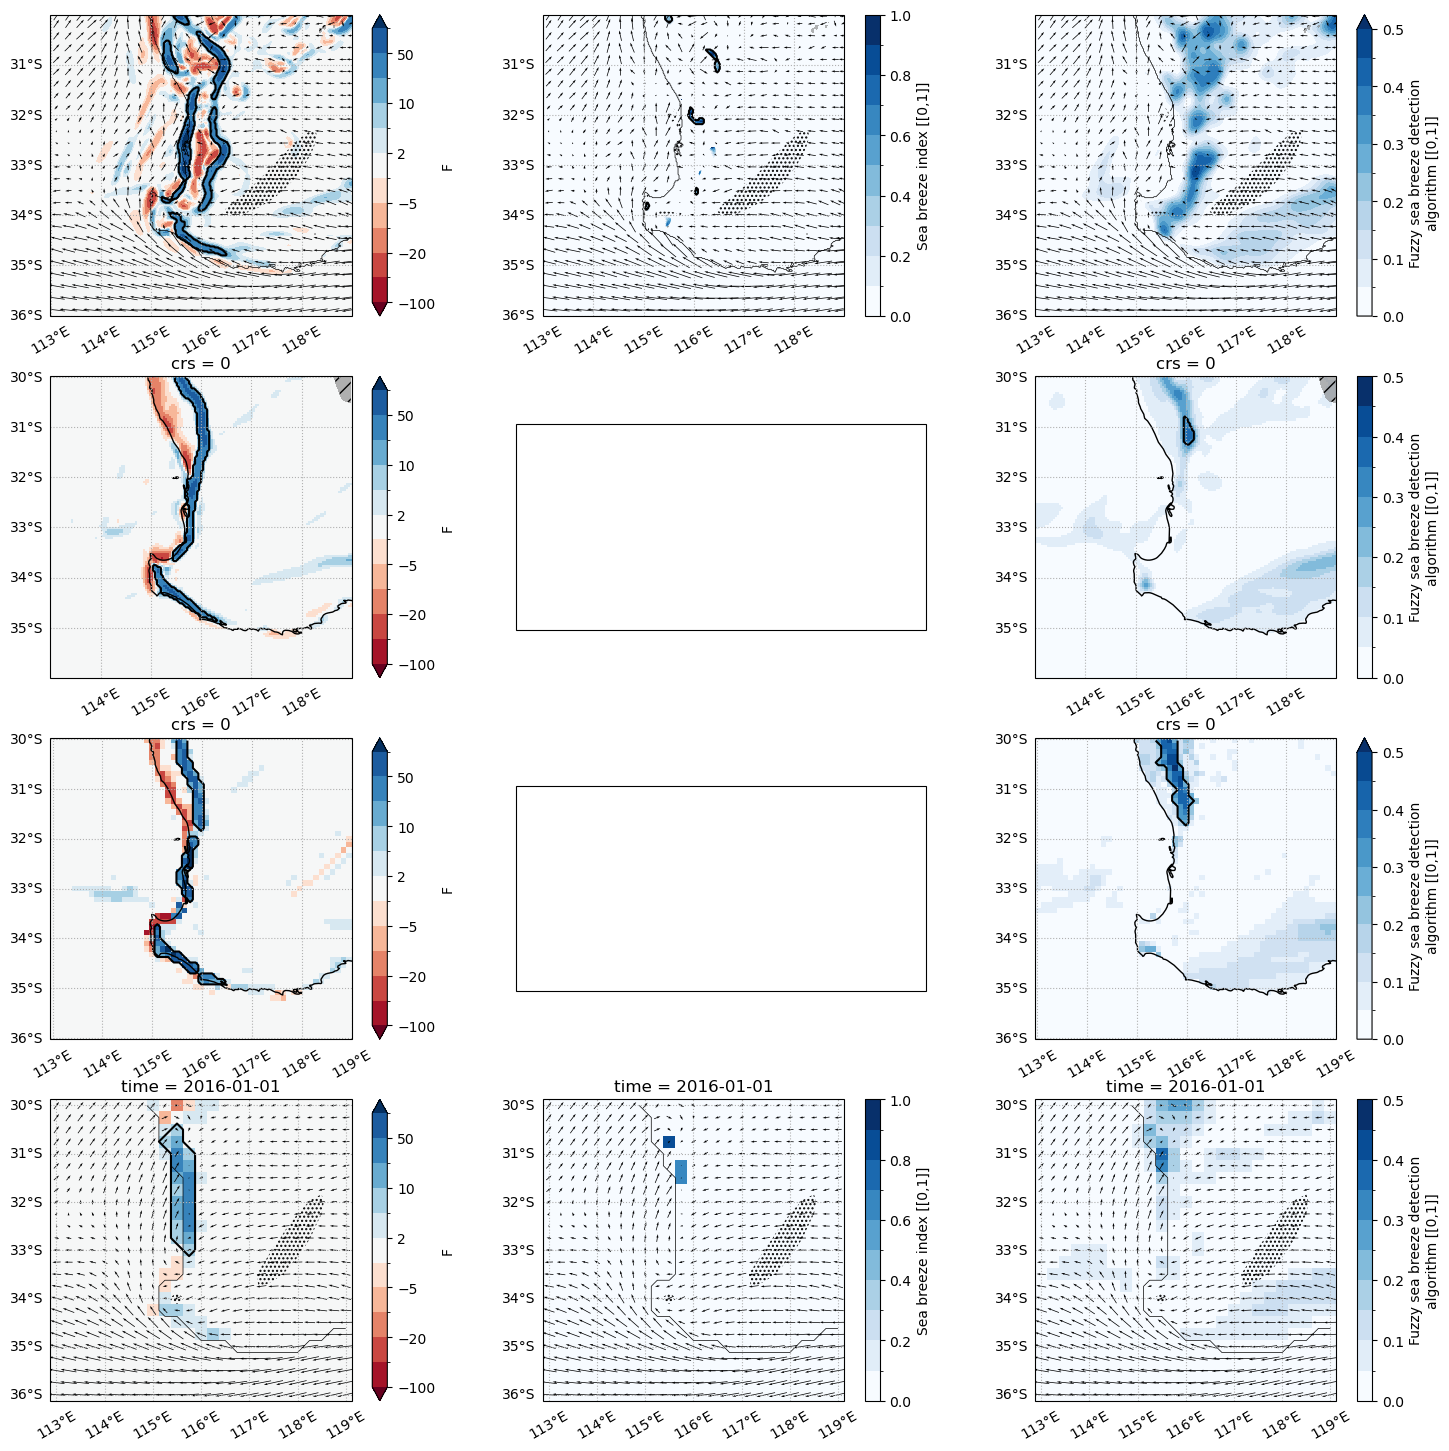

In [17]:
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
time = "2016-01-07 08:00"
exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

plot_driver()

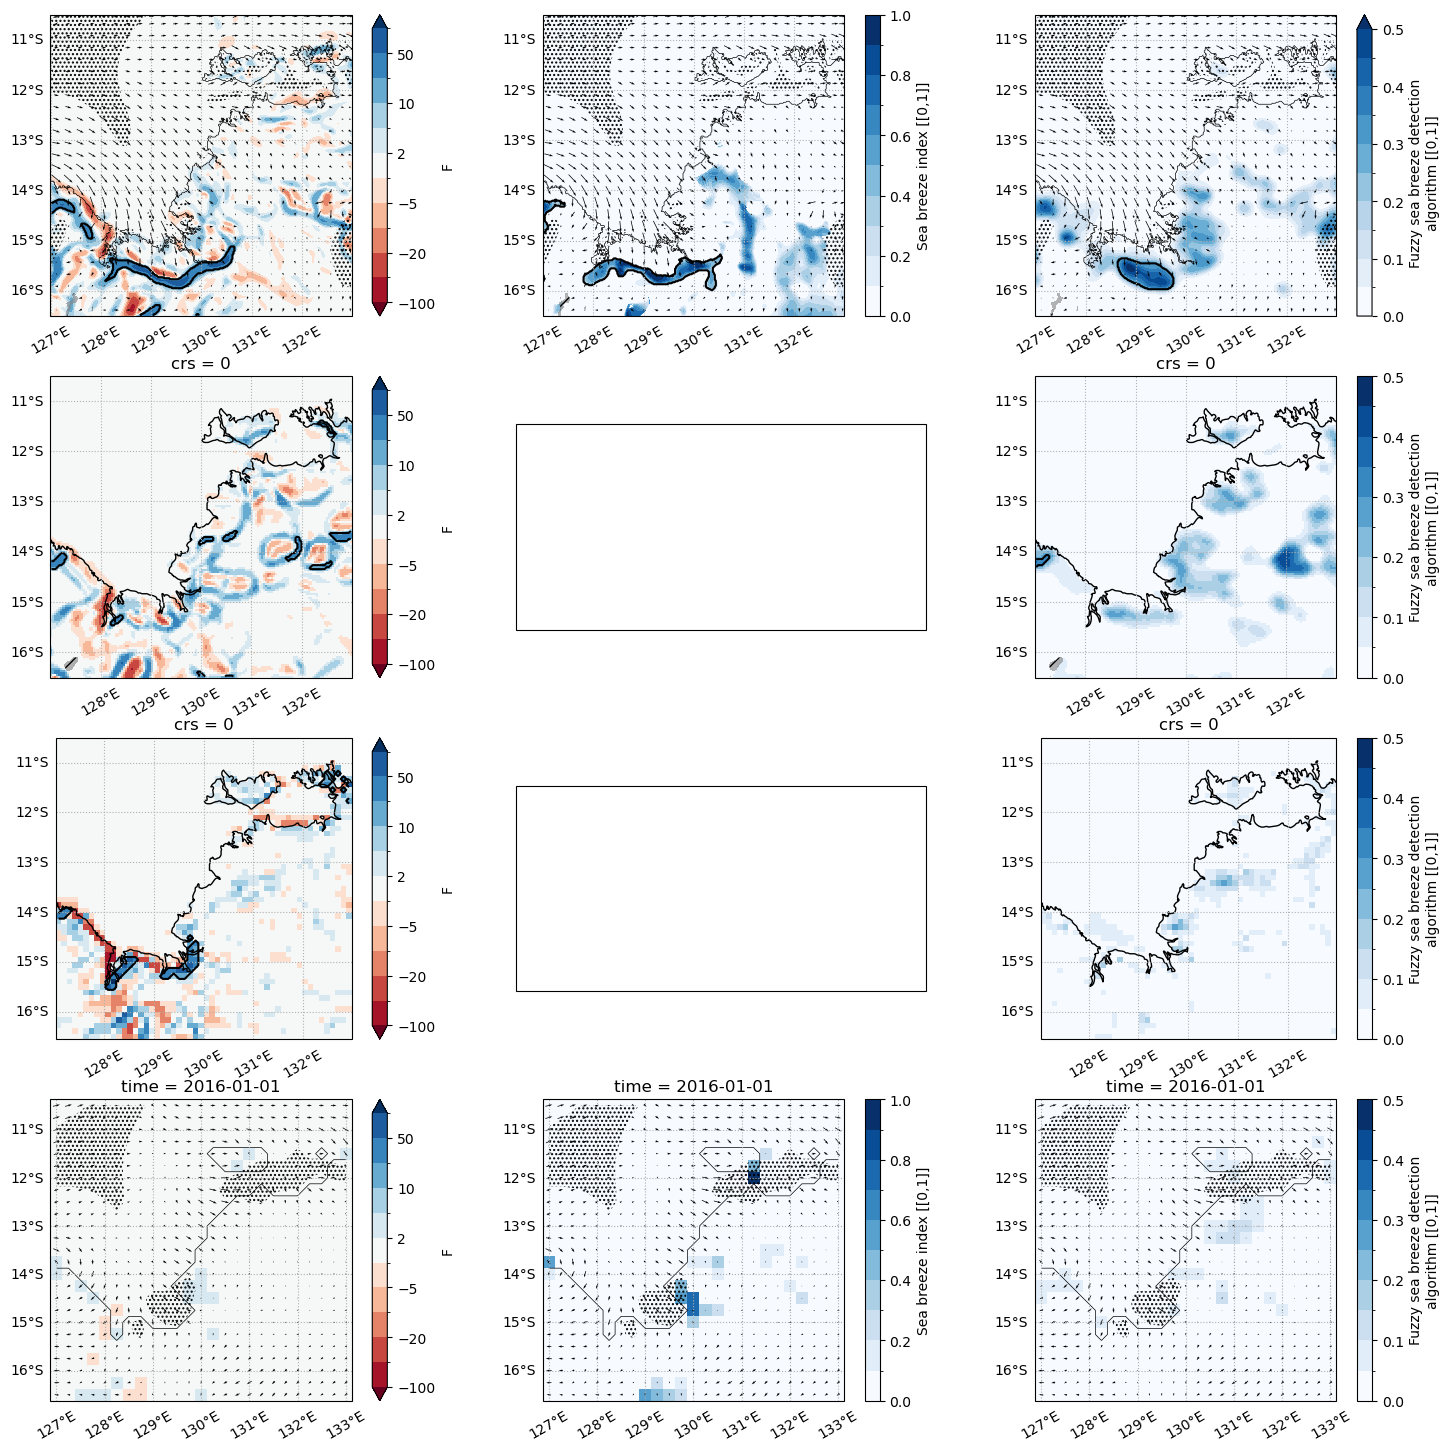

In [24]:
lat_slice = slice(-16.5,-10.5)
lon_slice = slice(127,133)
time = "2016-01-08 05:00"
exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

plot_driver()

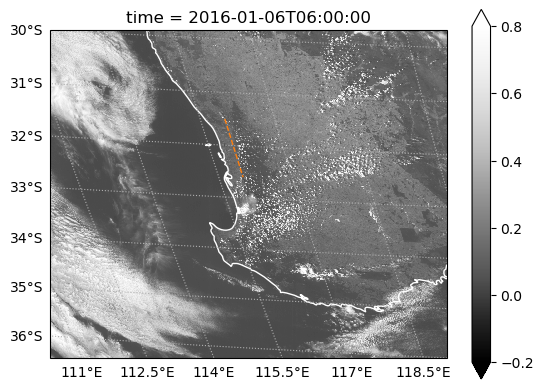

In [210]:
def load_sat(time,lon_slice,lat_slice):

    sat, pyproj_proj, ccrs_proj = load_obs.load_hima(pd.to_datetime(time))
    lons, lats = load_obs.get_lat_lons(sat, pyproj_proj)
    y_ind, x_ind = np.where((lons >= lon_slice.start) & (lons <= lon_slice.stop) & (lats <= lat_slice.stop) & (lats >= lat_slice.start))
    
    sat = sat.sel(
        y = slice(sat["y"][y_ind].max().values, sat["y"][y_ind].min().values),
        x = slice(sat["x"][x_ind].min().values, sat["x"][x_ind].max().values)
    ).channel_0003_corrected_reflectance

    return sat, ccrs_proj

def plot_sat(ax,ds):

    c = ds.plot(cmap="Greys_r",vmin=-0.2,vmax=0.8,ax=ax,add_colorbar=False)
    plt.colorbar(c,extend="both")
    ax.coastlines(color="white")
    ax.gridlines(draw_labels=["bottom","left"],ls=":")    

#sat, ccrs_proj = load_sat(time,lon_slice,lat_slice)
plot_sat(plt.axes(projection=ccrs_proj),sat)
plt.plot([116,116],[-31.5,-32.6],color="tab:orange",ls="--",lw=1,transform=ccrs.PlateCarree())

In [193]:


stn = load_obs.load_half_hourly_stn_obs(
    "WA",
    slice(
        pd.to_datetime(time) + dt.timedelta(hours=-12),
        pd.to_datetime(time) + dt.timedelta(hours=+12))
)
stn.sel(station=41).wspd.plot()
stn.sel(station=41).Tdew.plot()